In [1]:

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../fraud-detector/')
from feateng import FeatPipeline

In [2]:

###############################
# Variable Assignment and data read in
###############################
#TODO: make configurable
sampleRate = 0.1
raw = pd.read_csv("../data/input_data.csv").drop(columns = ["isFlaggedFraud"])
raw_sampled = pd.DataFrame.sample(raw, frac = sampleRate)


In [3]:
df = FeatPipeline.fit_transform(raw_sampled)
print("Debugging log - FE step complete:")
df.head()

Debugging log - FE step complete:


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,stepDay,stepHour,stepWeekDay,isDestMerchant,isDestBalanceNewZero,isDestBalanceOldZero,isOrigBalanceNewZero,isOrigBalanceOldZero
4144797,303,PAYMENT,8787.65,C985497128,90982.45,82194.80,M2022321351,0.00,0.00,0,0,13.0,15.0,6.0,1,1,1,0,0
1534415,154,CASH_IN,174480.86,C1996347533,10903.00,185383.86,C130443919,435892.76,261411.90,0,0,7.0,10.0,0.0,0,0,0,0,0
1782541,162,PAYMENT,1541.53,C1976939594,0.00,0.00,M1654949188,0.00,0.00,0,0,7.0,18.0,0.0,1,1,1,1,1
2967625,231,CASH_OUT,299260.02,C1489648854,0.00,0.00,C1446853973,2026157.65,2325417.67,0,0,10.0,15.0,3.0,0,0,0,1,1
4681721,331,CASH_OUT,62795.63,C505110752,41113.00,0.00,C1968758164,0.00,62795.63,0,0,14.0,19.0,0.0,0,0,1,1,0


In [4]:
###############################
# More variable Assignment
###############################
#TODO: make configurable
target_feature = ["isFraud"]
id_features = ['nameDest', 'nameOrig']
all_features = df.columns.difference(target_feature).difference(id_features)
numeric_features = ['amount', 'newbalanceDest',
       'newbalanceOrig', 'oldbalanceDest', 'oldbalanceOrg', 'step', ]
categorical_features = ['stepDay', 'stepHour', 'type']
binary_features = ['isDestMerchant']
other_features = all_features.difference(numeric_features).difference(categorical_features).difference(binary_features)
other_features

Index(['isDestBalanceNewZero', 'isDestBalanceOldZero', 'isFlaggedFraud',
       'isOrigBalanceNewZero', 'isOrigBalanceOldZero', 'stepWeekDay'],
      dtype='object')

In [5]:
all_features

Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero', 'newbalanceDest', 'newbalanceOrig',
       'oldbalanceDest', 'oldbalanceOrg', 'step', 'stepDay', 'stepHour',
       'stepWeekDay', 'type'],
      dtype='object')

In [6]:
y = df[target_feature]
X_train, X_test, y_train, y_test = train_test_split(df[all_features], np.array(df[target_feature]), test_size = 0.3,random_state=2, stratify=y)


In [7]:
# Generate roc_auc curves
roc_auc_train_df = pd.DataFrame(columns=[
       'features', 'logistic_regression', 'random_forest', 'gradient_boosting',
])

roc_auc_test_df = pd.DataFrame(columns=[
       'features', 'logistic_regression', 'random_forest', 'gradient_boosting'
])

for i in range(len(all_features)):
       lr = joblib.load(f'../models/logisticRegression_{i + 1}.pkl')
       rf = joblib.load(f'../models/randomForest_{i + 1}.pkl')
       gb = joblib.load(f'../models/gradientBoosting_{i + 1}.pkl')

       features = all_features[:i + 1]
       print("Iteration " + str(i) + ", features: ", features)
       # # Append predictions
       # df['lrPrediction'] = lr.predict(df[features])
       # df['rfPrediction'] = rf.predict(df[features])
       # df['gbPrediction'] = gb.predict(df[features])

       # # Append predictions
       # df['lrPredictionProba'] = lr.predict_proba(df[features])
       # df['rfPredictionProba'] = rf.predict_proba(df[features])
       # df['gbPredictionProba'] = gb.predict_proba(df[features])

       # roc auc - train data
       lr_roc_auc_score_train = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
       gb_roc_auc_score_train = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
       rf_roc_auc_score_train = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])
       roc_auc_train_df.loc[len(roc_auc_test_df)] = [
              i + 1, lr_roc_auc_score_train, rf_roc_auc_score_train, gb_roc_auc_score_train
       ]

       # roc auc - test data
       lr_roc_auc_score_test = roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])
       gb_roc_auc_score_test = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
       rf_roc_auc_score_test = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
       roc_auc_test_df.loc[len(roc_auc_test_df)] = [
              i + 1, lr_roc_auc_score_test, rf_roc_auc_score_test, gb_roc_auc_score_test
       ]



Iteration 0, features:  Index(['amount'], dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 1, features:  Index(['amount', 'isDestBalanceNewZero'], dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 2, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero'], dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 3, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 4, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 5, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 6, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 7, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero', 'newbalanceDest'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 8, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero', 'newbalanceDest', 'newbalanceOrig'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 9, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero', 'newbalanceDest', 'newbalanceOrig',
       'oldbalanceDest'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

Iteration 10, features:  Index(['amount', 'isDestBalanceNewZero', 'isDestBalanceOldZero',
       'isDestMerchant', 'isFlaggedFraud', 'isOrigBalanceNewZero',
       'isOrigBalanceOldZero', 'newbalanceDest', 'newbalanceOrig',
       'oldbalanceDest', 'oldbalanceOrg'],
      dtype='object')


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anacon

FileNotFoundError: [Errno 2] No such file or directory: '../models/logisticRegression_12.pkl'

In [9]:
roc_auc_train_df



,features,logistic_regression,random_forest,gradient_boosting
0,1.0,0.800812,0.799009,0.800288
1,2.0,0.800812,0.797738,0.800288
2,3.0,0.800812,0.797641,0.800288
3,4.0,0.811473,0.814171,0.822100
4,5.0,0.811473,0.811463,0.822100
5,6.0,0.811473,0.806611,0.822100
6,7.0,0.811477,0.808156,0.603643
7,8.0,0.858830,0.821898,0.819339
8,9.0,0.882131,0.849004,0.840454
9,10.0,0.881999,0.742000,0.669604


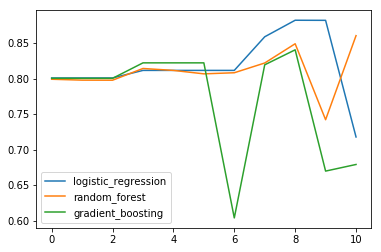

In [10]:
roc_auc_train_df[[col for col in roc_auc_train_df.columns if col not in ['features']]].plot();


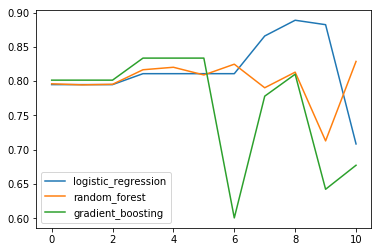

In [11]:
roc_auc_test_df[[col for col in roc_auc_test_df.columns if col not in ['features']]].plot();


In [12]:
roc_auc_test_df['gb_diff'] = roc_auc_test_df['gradient_boosting'] - roc_auc_test_df['gradient_boosting'].shift(1)
roc_auc_test_df['rf_diff'] = roc_auc_test_df['random_forest'] - roc_auc_test_df['random_forest'].shift(1)
roc_auc_test_df[['features', 'gradient_boosting', 'random_forest', 'gb_diff', 'rf_diff']]



,features,gradient_boosting,random_forest,gb_diff,rf_diff
0,1.0,0.801427,0.796099,NaN,NaN
1,2.0,0.801427,0.794563,0.000000,-0.001535
2,3.0,0.801427,0.795362,0.000000,0.000799
3,4.0,0.833570,0.816589,0.032143,0.021227
4,5.0,0.833570,0.820217,0.000000,0.003628
5,6.0,0.833570,0.809002,0.000000,-0.011215
6,7.0,0.600537,0.824689,-0.233033,0.015687
7,8.0,0.778064,0.790327,0.177528,-0.034361
8,9.0,0.810073,0.813100,0.032009,0.022772
9,10.0,0.642314,0.712857,-0.167759,-0.100242


## Pick a model type

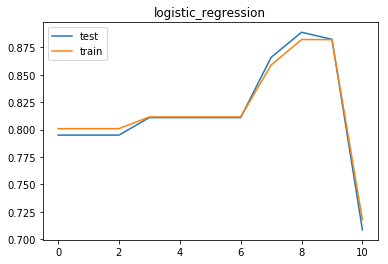

In [24]:
# Compare roa_auc on train vs test set
model_type = "logistic_regression"

plt.plot(roc_auc_test_df[model_type], label = 'test');
plt.plot(roc_auc_train_df[model_type], label = 'train');
plt.legend(loc = 'best');
plt.title(model_type);



# Now pick a model

In [25]:
# Choose model: 
model_chosen = 'logisticRegression_7'
model = joblib.load(f'../models/{model_chosen}.pkl')
y_test_pred = model.predict(X_test)
y_test_pred_proba = model.predict_proba(X_test)
y_test_pred_proba_posit = y_test_pred_proba[:, 1]

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [ ]:
# select features of interest
model.predict(df[all_features])
model.predict_proba(df[all_features])[:,1]

190637 242


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Confusion matrix
[[190333    304]
 [   216     26]]


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Normalized confusion matrix
[[0.99840535 0.00159465]
 [0.89256198 0.10743802]]


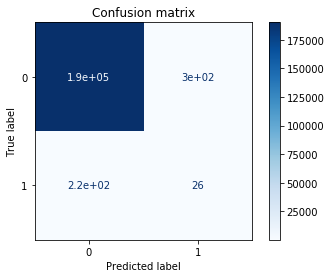

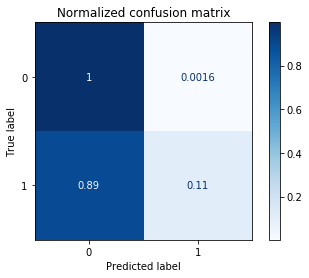

In [26]:
y_test_zeros = pd.DataFrame(y_test)[0].value_counts()[0]
y_test_ones = pd.DataFrame(y_test)[0].value_counts()[1]
print(y_test_zeros, y_test_ones)

from sklearn.metrics import plot_confusion_matrix
titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)




/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


Text(0.5, 1.0, '2-class Precision-Recall curve: Average Precision=0.00')

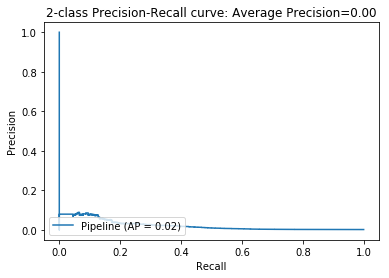

In [27]:
# PR curve focuses on the minority class, whereas the ROC curve covers both classes.
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

average_precision = average_precision_score(y_test, y_test_pred_proba[:,0])


disp = plot_precision_recall_curve(model, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'Average Precision={0:0.2f}'.format(average_precision))

Counter({0: 190549, 1: 330})


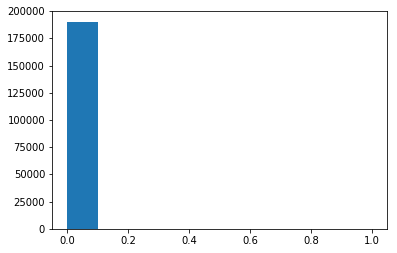

,pred,pred_prob
180,1,0.997157
355,1,0.991060
502,1,1.000000
1023,1,0.671807
1359,1,0.927166


In [28]:
# summarize the distribution of class labels
from collections import Counter
print(Counter(y_test_pred))
# create a histogram of the predicted probabilities of fraud = 1
plt.hist(y_test_pred_proba[:,1], bins=10)
plt.show()

y_pred_df = pd.concat([pd.DataFrame(y_test_pred), pd.DataFrame(y_test_pred_proba[:,1])], axis=1)
y_pred_df.columns = ["pred", "pred_prob"]

y_pred_df[y_pred_df["pred"]==1].head()



In [29]:
y_pred_df.head()

,pred,pred_prob
0,0,0.002133
1,0,0.002178
2,0,0.003633
3,0,0.002735
4,0,0.002053


## Potential solutions to highly imbalanced data:
- Over/undersampling strategies
- Ideally, we would want the business to provide or help us estimate the cost of failing to detect a case of fraud (False Negative) or flagging as such a transaction that is instead genuine (False Positive). We can then use this to build a **loss function** that can be passed to the model, either for training stage (ideal, see here: https://towardsdatascience.com/custom-loss-functions-for-gradient-boosting-f79c1b40466d) or for hyper-parameter tuning.



In [19]:
## UDF for scoring in Spark
# from dna_utils import SparkConfig
# spark = SparkConfig(app_name="modelling",).connect()

# train_df = pd.DataFrame(columns = [
#     'features', 'logistic_regression', 'gradient_boosting', 'random_forest'
# ])

# test_df = pd.DataFrame(columns = [
#     'features', 'logistic_regression', 'gradient_boosting', 'random_forest'
# ])

# for i in range(len(all_features)):
#     lr = joblib.load(f'../models/logisticRegression_{i+1}.pkl')
#     gb = joblib.load(f'../models/gradientBoosting_{i+1}.pkl')
#     rf = joblib.load(f'../models/randomForest_{i+1}.pkl')

#     features = all_feats[:i+1]

#     logistic_regression = roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1])
#     gradient_boosting = roc_auc_score(y_train, gb.predict_proba(X_train)[:, 1])
#     random_forest = roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1])

#     train_df.loc[len(train_df)] = [
#         i + 1, logistic_regression, gradient_boosting, random_forest
#     ]


#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_lr(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in lr.predict_proba(X))

#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_gb(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in gb.predict_proba(X))

#     @F.pandas_udf(returnType = T.ArrayType(T.DoubleType()))
#     def predict_rf(*cols):
#         X = pd.concat(cols, axis = 1)
#         return pd.Series(row.tolist() for row in rf.predict_proba(X))

#     df2 = spark.createDataFrame(df)\
#         .withColumn('lrPrediction', predict_lr(*features))\
#         .withColumn('gbPrediction', predict_gb(*features))\
#         .withColumn('rfPrediction', predict_rf(*features))\
#         [['target',
#           F.col('lrPrediction')[1].alias('lr_prediction'),
#           F.col('gbPrediction')[1].alias('gb_prediction'),
#           F.col('rfPrediction')[1].alias('rf_prediction')
#          ]]\
#         .toPandas()

#     logistic_regression_test = roc_auc_score(df2['target'], df2['lr_prediction'])
#     gradient_boosting_test = roc_auc_score(df2['target'], df2['gb_prediction'])
#     random_forest_test = roc_auc_score(df2['target'], df2['rf_prediction'])

#     test_df.loc[len(test_df)] = [
#         i + 1, gradient_boosting_test, random_forest_test, logistic_regression_test
#     ]

#     print(i + 1, ' done')

In [44]:
np.mean(model.predict_proba(X_train_cp)[:, 0])
np.mean(model.predict_proba(X_train_cp)[:, 1])

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


0.004040509055441245

In [38]:
X_train_cp = X_train.copy()
X_train_cp['pred'] = model.predict(X_train_cp)
X_train_cp['pred_proba_fraud'] = model.predict_proba(X_train_cp)[:, 1]

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [46]:

model.predict()

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/compose/_column_transformer.py:430: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


,amount,isDestBalanceNewZero,isDestBalanceOldZero,isDestMerchant,isFlaggedFraud,isOrigBalanceNewZero,isOrigBalanceOldZero,newbalanceDest,newbalanceOrig,oldbalanceDest,oldbalanceOrg,step,stepDay,stepHour,stepWeekDay,type,pred,pred_proba,pred_proba_fraud
5422769,62806.61,0,0,0,0,1,0,755475.51,0.00,692668.90,293.00,378,16.0,18.0,2.0,CASH_OUT,0,0.002156,0.002156
6286441,1015310.89,0,0,0,0,1,0,2035233.29,0.00,1019922.40,4936.88,661,28.0,13.0,0.0,TRANSFER,0,0.006777,0.006777
4825984,108847.35,0,0,0,0,1,1,541616.18,0.00,432768.83,0.00,346,15.0,10.0,1.0,CASH_OUT,0,0.002279,0.002279
863497,496171.48,0,1,0,0,1,0,496171.48,0.00,0.00,22034.00,42,2.0,18.0,2.0,TRANSFER,0,0.003633,0.003633
471949,478868.76,0,1,0,0,1,1,498994.61,0.00,0.00,0.00,19,1.0,19.0,1.0,CASH_OUT,0,0.003558,0.003558
1066279,225263.43,0,0,0,0,0,0,90932.94,3074138.18,316196.37,2848874.76,120,5.0,24.0,5.0,CASH_IN,0,0.002622,0.002622
305044,536498.33,0,0,0,0,1,0,575433.35,0.00,38935.02,10626.00,15,1.0,15.0,1.0,CASH_OUT,0,0.003813,0.003813
2668115,18721.12,1,1,1,0,0,0,0.00,90321.67,0.00,109042.80,210,9.0,18.0,2.0,PAYMENT,0,0.000241,0.000241
2262715,59877.65,0,0,0,0,0,0,525730.84,98699.35,465853.19,158577.00,187,8.0,19.0,1.0,CASH_OUT,0,0.002148,0.002148
246788,328198.13,0,0,0,0,1,0,73801.24,0.00,62767.68,244.00,14,1.0,14.0,1.0,CASH_OUT,0,0.002968,0.002968
